# Import

In [23]:
import os
from itertools import chain

import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import nibabel as nib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DataLoader

In [4]:
class MyDataset(Dataset):
    def __init__(self, test_size=0.2, test=False):
        
        data_files = glob('../../brainmask_nii/*.nii')
        data_files.sort()
        
        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))
        
        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname  = [data_files[i] for i in shuffled_index[-test_num:]]
        
        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        
        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file.age_zscored.values[shuffled_index[-test_num:]]
            
        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file.age_zscored.values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        #print(idx)
        x = torch.tensor(nib.load(self.data_files[idx]).get_fdata())[None, :, :].float()
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

train_dset = MyDataset()
test_dset  = MyDataset(test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

# 3D Convolution Model

## Modeling

In [5]:
class Conv3d(nn.Module):
    
    def __init__(self):
        super(Conv3d, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 5, 3),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=3, stride=3)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv3d(8, 16, 5, 3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=3, stride=3)
        )
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [6]:
model = Conv3d().float()
model.to(device)

Conv3d(
  (layer1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(5, 5, 5), stride=(3, 3, 3))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 5, 5), stride=(3, 3, 3))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

## Debug

In [7]:
# for i, (x, y)in enumerate(test_loader):
#     if i < 1:
#         x = x.to(device)
#         y = y.to(device)
#         print(model.forward(x), y)
#     else:
#         break

## Passing through Model

In [8]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [9]:
epochs = range(20)

trn_losses, tst_losses = [], []

for e in epochs:
    
    trn_bth_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)
        
        loss = loss_fn(y_pred, y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()

        trn_bth_loss += loss.item()
        
        if not i % 20:
            print(f'{i:<3}th Batch. Loss: {loss.item():.3f}')

    torch.cuda.empty_cache()
    trn_losses.append(trn_bth_loss / len(train_loader))
        
        
    tst_bth_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)
            loss = loss_fn(y_pred, y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    tst_losses.append(tst_bth_loss / len(test_loader))
    torch.cuda.empty_cache()
    
    # Print
    print(f'EPOCHS {e} | TRAIN :: [LOSS] {trn_losses[-1]:.3f} | VALID :: [LOSS] {tst_losses[-1]:.3f}')

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0  th Batch. Loss: 0.499
20 th Batch. Loss: 0.962
40 th Batch. Loss: 1.196
60 th Batch. Loss: 0.369
80 th Batch. Loss: 1.207
100th Batch. Loss: 0.862


C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCHS 0 | TRAIN :: [LOSS] 1.054 | VALID :: [LOSS] 1.157
0  th Batch. Loss: 0.751
20 th Batch. Loss: 0.984
40 th Batch. Loss: 1.208
60 th Batch. Loss: 0.366
80 th Batch. Loss: 1.078
100th Batch. Loss: 0.656
EPOCHS 1 | TRAIN :: [LOSS] 1.019 | VALID :: [LOSS] 1.095
0  th Batch. Loss: 0.572
20 th Batch. Loss: 0.933
40 th Batch. Loss: 1.145
60 th Batch. Loss: 0.398
80 th Batch. Loss: 0.995
100th Batch. Loss: 0.642
EPOCHS 2 | TRAIN :: [LOSS] 1.004 | VALID :: [LOSS] 1.059
0  th Batch. Loss: 0.405
20 th Batch. Loss: 0.976
40 th Batch. Loss: 1.148
60 th Batch. Loss: 0.406
80 th Batch. Loss: 0.982
100th Batch. Loss: 0.652
EPOCHS 3 | TRAIN :: [LOSS] 0.992 | VALID :: [LOSS] 1.058
0  th Batch. Loss: 0.395
20 th Batch. Loss: 0.990
40 th Batch. Loss: 1.156
60 th Batch. Loss: 0.409
80 th Batch. Loss: 0.977
100th Batch. Loss: 0.656
EPOCHS 4 | TRAIN :: [LOSS] 0.987 | VALID :: [LOSS] 1.058
0  th Batch. Loss: 0.386
20 th Batch. Loss: 1.000
40 th Batch. Loss: 1.161
60 th Batch. Loss: 0.421
80 th Batch. Lo

# Plot Result

### Loss

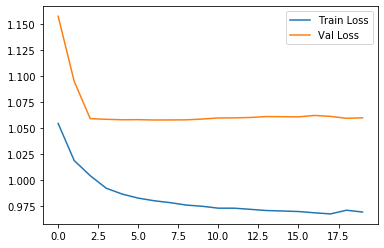

In [10]:
plt.plot(trn_losses)
plt.plot(tst_losses)
plt.legend(['Train Loss', 'Val Loss'])
plt.show()

### Regression Accuracy

In [16]:
def plot_result(trues, preds):
    preds = np.array(list(chain(*preds)))
    trues = np.array(list(chain(*trues)))
    
    cut = max(max(abs(preds)), max(abs(trues)))
    cuts = [-cut, cut]
              
    plt.scatter(preds, trues)
    plt.xlim(*cuts)
    plt.ylim(*cuts)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title('Train Dataset Prediction')
    domain = np.linspace(*cuts, 100)
    plt.plot(domain, domain, c='black')
    plt.show()

### Train

In [17]:
model.eval()
train_true, train_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        train_pred.append(y_pred.to('cpu'))
        train_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

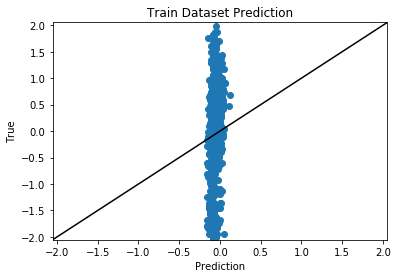

In [18]:
plot_result(train_true, train_pred)

### Test

In [24]:
model.eval()
test_true, test_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(test_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        test_pred.append(y_pred.to('cpu'))
        test_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

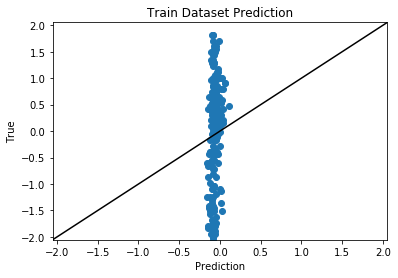

In [25]:
plot_result(test_true, test_pred)